In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

def add_zip_file(zip_filepath, extract_to):
  try:
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
      zip_ref.extractall(extract_to)
      print(f"Zip file '{zip_filepath}' extracted to '{extract_to}'.")
  except FileNotFoundError:
    print(f"Error: Zip file '{zip_filepath}' not found.")
  except zipfile.BadZipFile:
    print(f"Error: Invalid zip file '{zip_filepath}'.")

zip_file_path = "/content/drive/MyDrive/dataset.zip"
extract_directory = "/content/dataset"
add_zip_file(zip_file_path, extract_directory)


Zip file '/content/drive/MyDrive/dataset.zip' extracted to '/content/dataset'.


In [4]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Define augmentations
augmentations = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomScale(scale_limit=0.2, p=0.3),
    A.GaussianBlur(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.Resize(224, 224)
])

# Parameters
INPUT_DIR = '/content/dataset/dataset/train'
OUTPUT_DIR = 'augmented_data'
IMAGES_PER_CLASS = 100

# Target classes
target_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create output structure
os.makedirs(OUTPUT_DIR, exist_ok=True)

for class_name in target_classes:
    input_class_path = os.path.join(INPUT_DIR, class_name)
    output_class_path = os.path.join(OUTPUT_DIR, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # Load original images
    original_images = [os.path.join(input_class_path, fname)
                       for fname in os.listdir(input_class_path)
                       if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

    count = 0
    print(f"Generating for class: {class_name}")
    while count < IMAGES_PER_CLASS:
        for img_path in original_images:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            augmented = augmentations(image=img)['image']
            output_path = os.path.join(output_class_path, f'{class_name}_{count}.jpg')
            cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

            count += 1
            if count >= IMAGES_PER_CLASS:
                break

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Generating for class: angry
Generating for class: disgust
Generating for class: fear
Generating for class: happy
Generating for class: neutral
Generating for class: sad
Generating for class: surprise


In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "checkpoints/model-{epoch:02d}-{val_loss:.2f}.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)


In [6]:
# prompt: you need to resize the images to 256*256 adding white background around them but do not crop it

import cv2
import numpy as np

def resize_with_padding(image_path, output_path, size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return

    h, w = img.shape[:2]
    ratio = min(size[0] / h, size[1] / w)
    new_h, new_w = int(h * ratio), int(w * ratio)
    resized_img = cv2.resize(img, (new_w, new_h))

    delta_w = size[1] - new_w
    delta_h = size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    cv2.imwrite(output_path, padded_img)

# Example usage (replace with your directory and file paths):
import os

input_dir = "/content/augmented_data" # Example input directory
output_dir = "/content/resized_data" # Example output directory

os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if os.path.isdir(class_path):
        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for filename in os.listdir(class_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                input_path = os.path.join(class_path, filename)
                output_path = os.path.join(output_class_path, filename)
                resize_with_padding(input_path, output_path)


In [7]:
import os
import random
from shutil import copyfile

def train_test_split(source_dir, train_dir, test_dir, split_ratio=0.8):
    """Splits data into training and testing sets.

    Args:
        source_dir: Path to the source directory.
        train_dir: Path to the training directory.
        test_dir: Path to the testing directory.
        split_ratio: Ratio of data for training (default: 0.8).
    """

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):  # Check if it's a directory
            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)
            images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(images) # shuffles the images randomly
            split_index = int(len(images) * split_ratio)
            train_images = images[:split_index]
            test_images = images[split_index:]

            for image in train_images:
                source_path = os.path.join(class_path, image)
                destination_path = os.path.join(train_class_dir, image)
                copyfile(source_path, destination_path)

            for image in test_images:
                source_path = os.path.join(class_path, image)
                destination_path = os.path.join(test_class_dir, image)
                copyfile(source_path, destination_path)

# Example usage
source_directory = "/content/resized_data"
train_directory = "/content/dataset/dataset/train"
test_directory = "/content/dataset/dataset/test"

train_test_split(source_directory, train_directory, test_directory)


In [8]:
print(target_classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


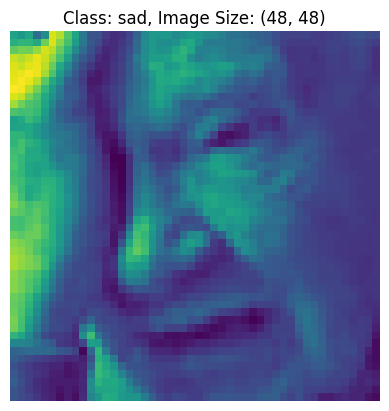

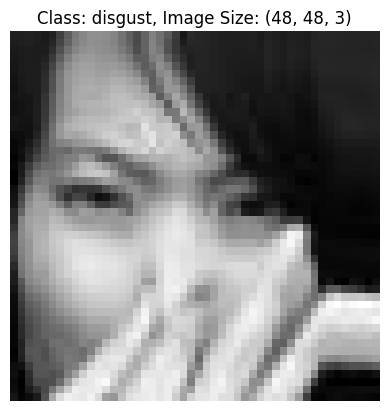

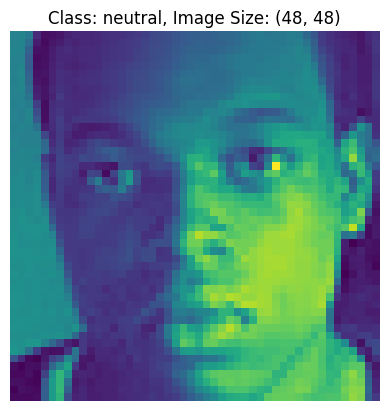

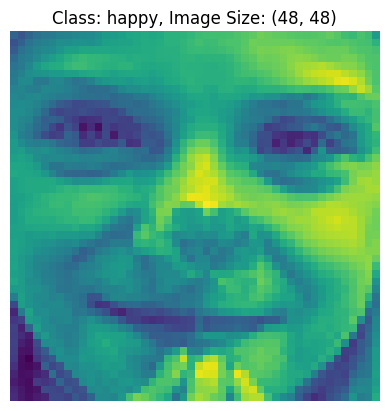

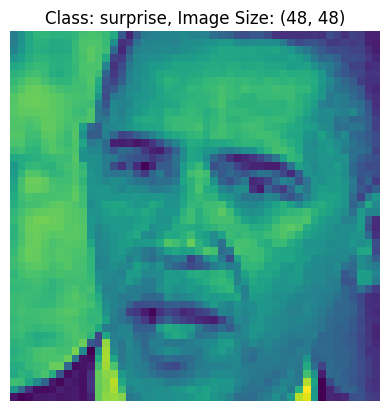

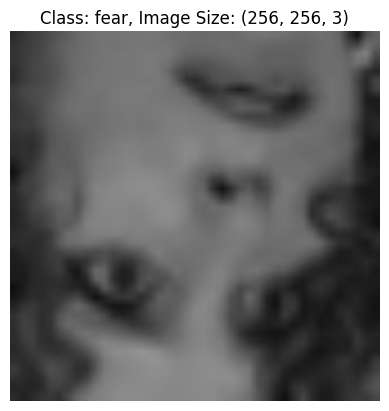

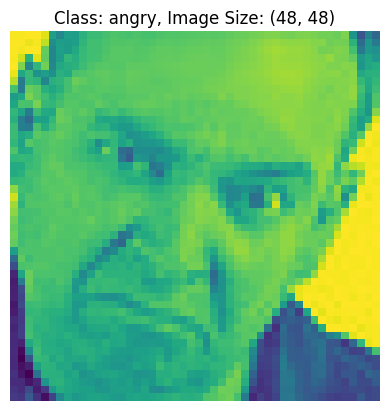

In [9]:
# prompt: view the actual image from each class with image size

import matplotlib.pyplot as plt
import os

# Assuming 'train' directory contains subdirectories for each class
train_dir = "/content/dataset/dataset/train"

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:  # Check if there are any image files in the directory
            image_path = os.path.join(class_path, image_files[0]) # Taking the first image for demonstration
            try:
              img = plt.imread(image_path)
              plt.imshow(img)
              plt.title(f"Class: {class_name}, Image Size: {img.shape}")
              plt.axis('off')
              plt.show()
            except Exception as e:
                print(f"Error displaying image {image_path}: {e}")
        else:
            print(f"No image files found in directory: {class_path}")


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_directory = '/content/dataset/dataset/train'
validation_directory = '/content/dataset/dataset/test'
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

image_size = (256, 256)

batch_size = 8

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale = 1./255)

train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3984 images belonging to 7 classes.
Found 1553 images belonging to 7 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import layers, models, regularizers

image_size = (256, 256)
print("Image size:", image_size)

base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3))
print("Base model input shape:", base_model.input_shape)
print("Base model output shape:", base_model.output_shape)

model_dense = models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_size[0], image_size[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization added here
    # layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

model_dense.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_dense.summary()


Image size: (256, 256)
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model input shape: (None, 256, 256, 3)
Base model output shape: (None, 8, 8, 1024)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,044,679 (26.87 MB)

 Trainable params: 6,961,031 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [13]:
model_dense.save_weights('/content/model_weights.weights.h5')

In [12]:
model_dense.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
    )

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [16]:
epochs = 10
densenet_history = model_dense.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint,callback]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3023 - loss: 1.8661
Epoch 1: val_loss improved from inf to 1.52286, saving model to checkpoints/model-01-1.52.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 297s 251ms/step - accuracy: 0.3024 - loss: 1.8657 - val_accuracy: 0.4411 - val_loss: 1.5229
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4740 - loss: 1.4058
Epoch 2: val_loss improved from 1.52286 to 1.29694, saving model to checkpoints/model-02-1.30.keras
498/498 ━━━━━━━━━━━━━━━━━━━━ 111s 222ms/step - accuracy: 0.4740 - loss: 1.4057 - val_accuracy: 0.5113 - val_loss: 1.2969
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.5404 - loss: 1.2213
Epoch 3: val_loss did not improve from 1.29694
498/498 ━━━━━━━━━━━━━━━━━━━━ 106s 213ms/step - accuracy: 0.5404 - loss: 1.2213 - val_accuracy: 0.5248 - val_loss: 1.3251
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6150 - loss: 1.0666
Epoch 4: val_loss improved from 1.29694 to

In [17]:
model_dense.save('densenetmodel_classify.h5')
print("Model saved successfully")

Model saved successfully


In [18]:
# prompt: use the /content/dataset folder as test data and calculate the accuracy precision recall over all

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load the best saved model (replace with the actual path to your best model)
best_model = keras.models.load_model("/content/densenetmodel_classify.h5") # example

# Predict on the test data
test_dir = '/content/dataset/dataset/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=batch_size,  # Use the same batch size as training
    class_mode='categorical',
    shuffle=False  # Important: do not shuffle for evaluation
)

predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted') # Use 'weighted' for multi-class
recall = recall_score(true_classes, predicted_classes, average='weighted') # Use 'weighted' for multi-class


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Found 1553 images belonging to 7 classes.
195/195 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step
Accuracy: 0.6078557630392788
Precision: 0.622653999163083
Recall: 0.6078557630392788


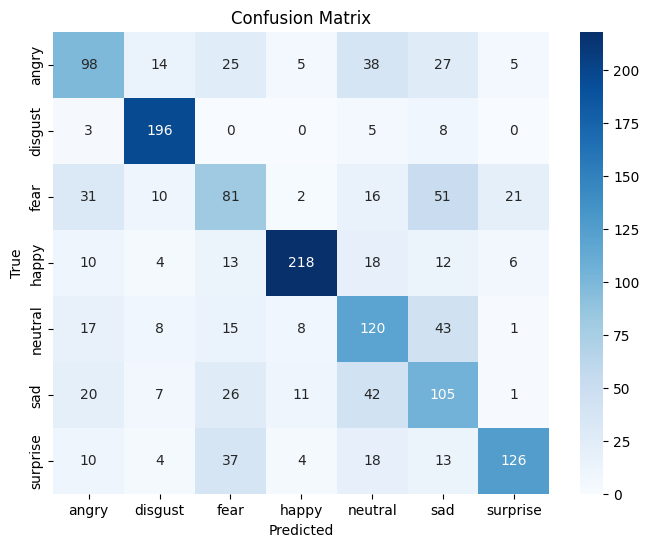

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class: angry
Prediction probabilities: [[9.9649209e-01 1.9703717e-03 2.2017979e-04 9.9010385e-06 1.0148430e-03
  2.8615189e-04 6.4307346e-06]]


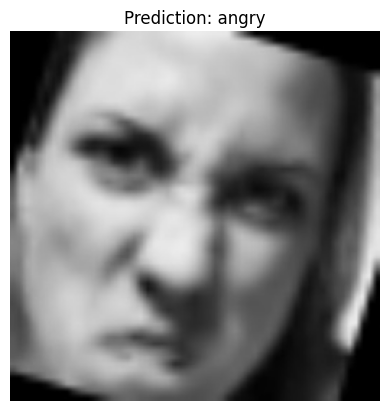

In [22]:
# prompt: generate the inference code to test the model on single images

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = keras.models.load_model("/content/densenetmodel_classify.h5")

# Define a function for image preprocessing and prediction
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Normalize the image

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    class_labels = list(train_generator.class_indices.keys())  # Get class labels from training generator
    predicted_label = class_labels[predicted_class]

    print(f"Predicted class: {predicted_label}")
    print(f"Prediction probabilities: {prediction}")

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_label}")
    plt.axis('off')
    plt.show()


# Example usage
image_path = "/content/dataset/dataset/test/angry/angry_1.jpg" # Replace with the actual path to your image
predict_image(image_path)
